<a href="https://colab.research.google.com/github/swilsonmfc/notebooks/blob/master/NLPTopicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Models
![alt text](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/05/22/sagemaker-ntm-1.gif)

# Setup

In [1]:
pip install pycaret

     |████████████████████████████████| 194kB 4.3MB/s 
     |████████████████████████████████| 1.6MB 14.9MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 7.0MB 17.0MB/s 
     |████████████████████████████████| 266kB 44.5MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 63.9MB 61kB/s 
     |████████████████████████████████| 133kB 41.4MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 3.2MB 37.9MB/s 
     |████████████████████████████████| 1.2MB 42.7MB/s 
     |████████████████████████████████| 389kB 46.4MB/s 
     |████████████████████████████████| 552kB 45.9MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 235kB 50.5MB/s 
     |████████████████████████████████| 604kB 40.7MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 2.1MB 40.6MB/s 
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pprint as pp

from sklearn.model_selection import train_test_split

import spacy

from collections import defaultdict

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.utils import simple_preprocess
from gensim.utils import lemmatize

from pycaret.regression import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Kaggle

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

## Seattle

In [5]:
!kaggle datasets download -d shanelev/seattle-airbnb-listings

  0% 0.00/533k [00:00<?, ?B/s]
100% 533k/533k [00:00<00:00, 36.4MB/s]


In [6]:
!unzip -q seattle-airbnb-listings.zip

In [7]:
!ls

sample_data  seattle_01.csv  seattle-airbnb-listings.zip


In [8]:
seattle_df = pd.read_csv('seattle_01.csv')

In [9]:
seattle_df.head()

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly
3,3,5682,8993,Entire home/apt,"Seattle, WA, United States",462,5.0,2,0.0,1.0,49,2018-12-20 04:11:25.482975,47.523980,-122.359891,0101000020E6100000FCC7427408975EC009E1D1C611C3...,"Cozy Studio, min. to downtown -WiFi",USD,nightly
4,4,6606,14942,Entire home/apt,"Seattle, WA, United States",134,4.5,2,1.0,1.0,90,2018-12-20 03:12:38.391711,47.654109,-122.337605,0101000020E6100000D47D00529B955EC07782FDD7B9D3...,"Fab, private seattle urban cottage!",USD,nightly


In [10]:
len(seattle_df)

7576

# Latent Semantic Analysis - LSA
* Sometimes called Latent Semantic Indexing - LSI
* Organize documents into topics
* The topics are hidden (latent)
* We can specify how many topics

## Technical Notes
* Construct a Document-Term matrix
  * Rows = Documents
  * Columns = Terms
  * Cells = Frequency of words
* Convert Document-Term matrix into TF-IDF Matrix
  * TF = Term Frequency
  * IDF = Inverse Document Frequency
  * Intuition:
    * TF - Word occurs frequently it's likely important
    * Stopwords are a problem (The, an, and) - occur frequenty in documents
    * IDF - If a word is rare considering all the documents it's likely more important
    * How rare is too rare?  Minimum threshold of appearances

![alt text](https://cdn.searchenginejournal.com/wp-content/uploads/2019/10/screenshot-1.png)

* Use matrix factorization to reduce dimensionality
  * Squeeze to K-dimensions
  * K is the number of topics
* LSA == PCA 
  * PCA - Principal Components
    * Find matrix U * V that approximates TF-IDF matrix
    * Minimize difference between TF-IDF and U * V
  * SVD - Singular value decomposition 
    * Increase explainability by constraining number of topics
  * NNMF - Non-Negative Matrix Factorization 
    * SVD + constraint where U & V > 0
* Truncated SVD yields three matrixes 
  * We can multiply them back together to approximate the original TF-IDF matrix
  * SVD decomposes a matrix into three other matrices. 
  * U* S * VT
  * U [Documents X Topics]
  * S [Topics X Topics] = Amount of Variance Explained
  * VT [Topics X Terms]
![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/Screenshot_7.png)


# Gensim Example 
![alt text](https://repository-images.githubusercontent.com/1349775/202c4680-8f7c-11e9-91c6-745fdcbeffe8)

In [11]:
documents = [
    "Human machine interface for lab abc computer applications May 10, 2000",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

## Documents

In [12]:
pp.pprint(documents)

['Human machine interface for lab abc computer applications May 10, 2000',
 'A survey of user opinion of computer system response time',
 'The EPS user interface management system',
 'System and human system engineering testing of EPS',
 'Relation of user perceived response time to error measurement',
 'The generation of random binary unordered trees',
 'The intersection graph of paths in trees',
 'Graph minors IV Widths of trees and well quasi ordering',
 'Graph minors A survey']


## Tokenize
* Remove stop words
* Make lower case

In [13]:
stoplist = set('for a of the and to in'.split()) # Where else can we get these
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]
pp.pprint(texts)

[['human',
  'machine',
  'interface',
  'lab',
  'abc',
  'computer',
  'applications',
  'may',
  '10,',
  '2000'],
 ['survey', 'user', 'opinion', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'management', 'system'],
 ['system', 'human', 'system', 'engineering', 'testing', 'eps'],
 ['relation', 'user', 'perceived', 'response', 'time', 'error', 'measurement'],
 ['generation', 'random', 'binary', 'unordered', 'trees'],
 ['intersection', 'graph', 'paths', 'trees'],
 ['graph', 'minors', 'iv', 'widths', 'trees', 'well', 'quasi', 'ordering'],
 ['graph', 'minors', 'survey']]


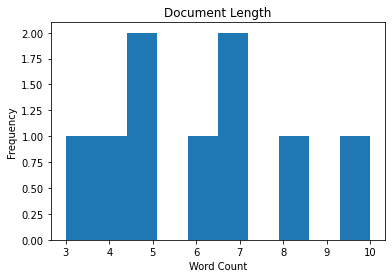

In [14]:
plt.hist([len(t) for t in texts])
plt.title('Document Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Low Frequency Words
* Drop words from the tokenized text appearing once

In [15]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]
pp.pprint(texts)

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]


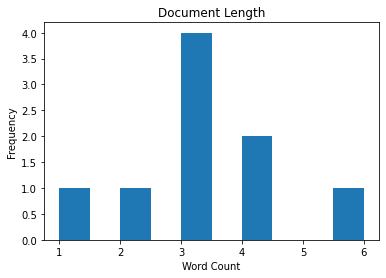

In [16]:
plt.hist([len(t) for t in texts])
plt.title('Document Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Dictionary

In [17]:
dictionary = corpora.Dictionary(texts)
print(dictionary)
for key in dictionary:
  print(key, dictionary[key])

Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)
0 computer
1 human
2 interface
3 response
4 survey
5 system
6 time
7 user
8 eps
9 trees
10 graph
11 minors


## Bag of Words
* Represented as list of tuples per document (word index, frequency)

In [18]:
corpus = [dictionary.doc2bow(text) for text in texts]
pp.pprint(corpus)

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]


## TF-IDF
* Term Frequency - Inverse Document Frequency
* Represented by a model in Gensim

In [19]:
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(0, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.44424552527467476), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.3244870206138555)]
[(2, 0.5710059809418182), (5, 0.4170757362022777), (7, 0.4170757362022777), (8, 0.5710059809418182)]
[(1, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (6, 0.6282580468670046), (7, 0.45889394536615247)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(4, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


## LSA Model
* Why Gensim vs TruncatedSVD?
  * Memory efficient (Constant Size)
  * Streamed corpora
  * One pass corpora (Streaming)
  * Distributed computing 

In [20]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) 
corpus_lsi = lsi_model[corpus_tfidf]  
lsi_model.print_topics(2, num_words=3)

[(0, '0.703*"trees" + 0.538*"graph" + 0.402*"minors"'),
 (1, '-0.460*"system" + -0.373*"user" + -0.332*"eps"')]

In [21]:
for doc, as_text in zip(corpus_lsi, documents):
    print(doc, as_text)

[(0, 0.06600783396090264), (1, -0.5200703306361851)] Human machine interface for lab abc computer applications May 10, 2000
[(0, 0.19667592859142471), (1, -0.7609563167700049)] A survey of user opinion of computer system response time
[(0, 0.08992639972446387), (1, -0.7241860626752517)] The EPS user interface management system
[(0, 0.07585847652178121), (1, -0.6320551586003438)] System and human system engineering testing of EPS
[(0, 0.1015029918498013), (1, -0.5737308483002957)] Relation of user perceived response time to error measurement
[(0, 0.7032108939378311), (1, 0.16115180214025748)] The generation of random binary unordered trees
[(0, 0.8774787673119833), (1, 0.1675890686465938)] The intersection graph of paths in trees
[(0, 0.9098624686818579), (1, 0.14086553628719004)] Graph minors IV Widths of trees and well quasi ordering
[(0, 0.6165825350569284), (1, -0.05392907566389349)] Graph minors A survey


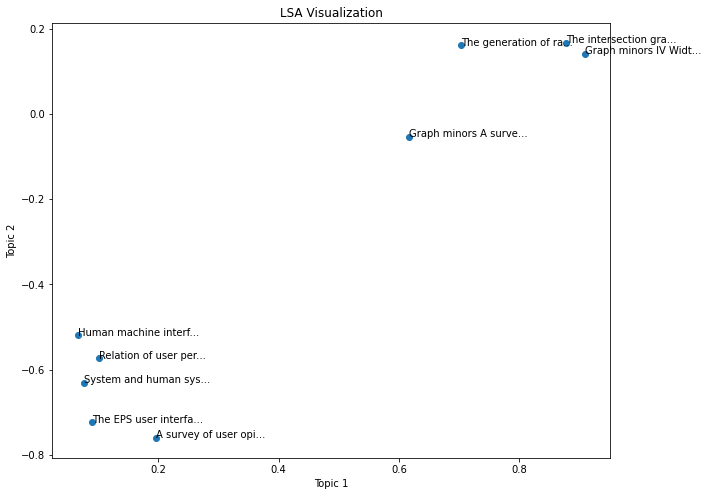

In [22]:
items = []
for doc, as_text in zip(corpus_lsi, documents):
    items.append({'Topic 1':doc[0][1], 'Topic 2': doc[1][1], 'Document': as_text[0:20] + '...'})
data = pd.DataFrame(items)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(data['Topic 1'], data['Topic 2'])

for index, row in data.iterrows():
    ax.annotate(row['Document'], (row['Topic 1'], row['Topic 2']))

plt.title('LSA Visualization');
plt.xlabel('Topic 1')
plt.ylabel('Topic 2');

In [73]:
data.dtypes

Topic 1     float64
Topic 2     float64
Document     object
dtype: object

## Similarity
* Distance 
* Cosine Similarity

In [24]:
doc = "Human computer interaction"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi_model[vec_bow]  # convert the query to LSI space

print(doc)
print(vec_lsi)

Human computer interaction
[(0, 0.07910475117444749), (1, -0.5732835243079405)]


In [25]:
index = similarities.MatrixSimilarity(lsi_model[corpus])
sims = index[vec_lsi]  # perform a similarity query against the corpus
pp.pprint(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

[(0, 0.9999408),
 (1, 0.9946708),
 (2, 0.9999428),
 (3, 0.999879),
 (4, 0.99935204),
 (5, -0.08804217),
 (6, -0.0515742),
 (7, -0.023664713),
 (8, 0.1938726)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# SpaCy Pipeline
![alt text](https://cdn-images-1.medium.com/freeze/max/1000/1*wqfF41Ysh-kV-fXMDGxSGg.jpeg?q=20)

## Documents

In [26]:
documents = [
    "Human machine interface for lab abc computer applications on May 10, 2000",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

In [27]:
paragraph = '. '.join(documents)
paragraph

'Human machine interface for lab abc computer applications on May 10, 2000. A survey of user opinion of computer system response time. The EPS user interface management system. System and human system engineering testing of EPS. Relation of user perceived response time to error measurement. The generation of random binary unordered trees. The intersection graph of paths in trees. Graph minors IV Widths of trees and well quasi ordering. Graph minors A survey'

## Loading Spacy

In [28]:
import spacy
nlp = spacy.load('en')

## Pipeline

In [29]:
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


## Processing
* Can tokenize document per item
* Can infer sentence boundaries by adding sentencizer to pipeline

In [30]:
nlp = spacy.load('en')
texts_spacy = [nlp(document) for document in documents]
texts_spacy

[Human machine interface for lab abc computer applications on May 10, 2000,
 A survey of user opinion of computer system response time,
 The EPS user interface management system,
 System and human system engineering testing of EPS,
 Relation of user perceived response time to error measurement,
 The generation of random binary unordered trees,
 The intersection graph of paths in trees,
 Graph minors IV Widths of trees and well quasi ordering,
 Graph minors A survey]

In [31]:
nlp_para = spacy.load('en')
nlp_para.add_pipe(nlp.create_pipe('sentencizer'))
texts_spacy = nlp_para(paragraph)
sentences = [sent.string.strip() for sent in texts_spacy.sents]
pp.pprint(sentences)

['Human machine interface for lab abc computer applications on May 10, 2000.',
 'A survey of user opinion of computer system response time.',
 'The EPS user interface management system.',
 'System and human system engineering testing of EPS.',
 'Relation of user perceived response time to error measurement.',
 'The generation of random binary unordered trees.',
 'The intersection graph of paths in trees.',
 'Graph minors IV Widths of trees and well quasi ordering.',
 'Graph minors',
 'A survey']


## Tokens
* Pipeline creates tokens
* Token attributes are populated depending on pipeline steps

In [32]:
texts_spacy = [nlp(document) for document in documents]

rows = []
for text in texts_spacy:
  for token in text:
    rows.append({'token': token.text,
                 'lower': token.lower_, 
                 'lemma': token.lemma_, 
                 'pos': token.pos_,
                 'shape': token.shape_,
                 'dependency': token.dep_,
                 'entity': token.ent_type_, 
                 'tag': token.tag_,
                 'stop': token.is_stop})
pd.DataFrame(rows)[0:10]

,token,lower,lemma,pos,shape,dependency,entity,tag,stop
0,Human,human,human,ADJ,Xxxxx,amod,,JJ,False
1,machine,machine,machine,NOUN,xxxx,compound,,NN,False
2,interface,interface,interface,NOUN,xxxx,ROOT,,NN,False
3,for,for,for,ADP,xxx,prep,,IN,True
4,lab,lab,lab,PROPN,xxx,compound,,NNP,False
5,abc,abc,abc,PROPN,xxx,compound,ORG,NNP,False
6,computer,computer,computer,NOUN,xxxx,compound,,NN,False
7,applications,applications,application,NOUN,xxxx,pobj,,NNS,False
8,on,on,on,ADP,xx,prep,,IN,True
9,May,may,May,PROPN,Xxx,pobj,DATE,NNP,True


## displaCy

In [33]:
import spacy
from spacy import displacy

In [34]:
doc = nlp(documents[0])
displacy.render(doc, style="dep", jupyter=True)

In [35]:
displacy.render(doc, style="ent", jupyter=True)

## SpaCy -> Gensim
* Gensim wants text
* token.text from SpaCy

# Latent Dirichlet Allocation - LDA
* Proposed in 2000 in the genetics field
* Applied to NLP in 2003 by Blei & Ng
* Generative probablistic model of a corpus (collection of documents)
  * Documents can be approximated with random mixtures over latent topics
  * Each topic is represented as a distribution over the words in the vocabulary

## Thought Experiment
* Corpus of Documents
* Latent Topics
  * Sports 
  * Politics
  * Scary
* Documents
  * Given document - what topic?
  * 10% Sports, 80% Politics, 10% Scary
  * 60% Sports, 20% Politics, 20% Scary
  * 33% Sports, 34% Politics, 33% Scary
  * Documents can be a mixture of topics!
* Words 
  * Given topic - what word?
  * Court: 40% Sports, 40% Politics, 20% Scary
  * Ghost: 10% Sports, 10% Politics, 60% Scary
  * Race : 40% Sports, 30% Politics, 10% Scary
  * Win  : 10% Sports, 20% Politics, 10% Scary
  * Words are a distribution over the vocabulary conditioned by the topic

## Dirichlet Distribution
* Hyperparameter alpha controls edge / center
![alt text](https://cdn-images-1.medium.com/max/900/0*mAmRqUT4gRoFj-eo.)

## Technical Notes
* Can we build a machine to generate documents with just dice?
* Approach:
  * How many documents?  Use the size of the corpus.
  * How many words (N) in "document"?  Use the corpus average length and draw from Poisson distribution. 
    * Expected Value = Average Length
    * Variance = Average Length
  * Choose Topic Mix from Dirichlet distribution (Theta)
    * Hyperparameter alpha (is our Dirichlet more focused in the center or to the edges)?
  * For each word (N):
    * Choose a topic (Z) from Multinomial distribution (Theta)
    * Choose a word conditioned on Topic (Z)
    * Note:  We don't write a document, but rather reproduce the "bag"
  * Repeat for each document in corpus
  * Select machine that "reconstructs" the original document the best
  * Repeat process
* After processing we get two matrixes
  * Words X Topics
  * Topics X Documents



# LSA vs LDA

![alt text](https://image2.slideserve.com/3877409/slide21-l.jpg)

* LSA
  * Keep things spread apart that were far apart to start
  * LSA has the advantage of good optimization
* LDA
  * Keep things close that were close together to start
  * More understandable 
  * Tends to keep frequently co-occurring words in the same topic

# Seattle - Dataset
* Use SpaCy to parse "name" field
* Use Gensim to:
  * Transform to tf-idf space
  * Transform to LSA space
  * Build a LDA Model
* Craft features from topics
* Build ML model to forecast AirBnB price

## Documents

In [36]:
documents = seattle_df.name.to_list()
documents[0:10]

['Casa Madrona - Urban Oasis, 1 block from the Park!',
 'Sweet Seattle Urban Homestead 2 Bdr',
 'Sunrise in Seattle Master Suite',
 'Cozy Studio, min. to downtown -WiFi',
 'Fab, private seattle urban cottage!',
 'Glorious sun room w/ memory foambed',
 'Downtown/Convention Ctr B&B - Nice!',
 'The Adorable Sweet Orange Craftsman',
 'The Coolest Tangerine Dream MIL! ',
 'the down home , spacious, central and fab!']

## Tokenize
* Skip stopwords
* Skip punctuation

In [37]:
nlp = spacy.load('en')
tokens = [nlp(document) for document in documents]
tokens[0:10]

[Casa Madrona - Urban Oasis, 1 block from the Park!,
 Sweet Seattle Urban Homestead 2 Bdr,
 Sunrise in Seattle Master Suite,
 Cozy Studio, min. to downtown -WiFi,
 Fab, private seattle urban cottage!,
 Glorious sun room w/ memory foambed,
 Downtown/Convention Ctr B&B - Nice!,
 The Adorable Sweet Orange Craftsman,
 The Coolest Tangerine Dream MIL! ,
 the down home , spacious, central and fab!]

In [38]:
texts = [
         [token.text for token in document
          if not token.is_stop and not token.is_punct]
         for document in tokens
        ]

## Dictionary

In [39]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(4297 unique tokens: ['1', 'Casa', 'Madrona', 'Oasis', 'Park']...)


## Bag of Words

In [40]:
corpus = [dictionary.doc2bow(text) for text in texts]

## TF-IDF

In [41]:
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]

## LSA Model

In [42]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5) 
corpus_lsi = lsi_model[corpus_tfidf]  
lsi_model.print_topics(5, num_words=3)

[(0, '0.329*"Seattle" + 0.274*"Hill" + 0.259*"Private"'),
 (1, '-0.537*"Hill" + -0.513*"Capitol" + 0.298*"Seattle"'),
 (2, '0.468*"Place" + 0.454*"Pike" + -0.282*"Hill"'),
 (3, '-0.557*"Queen" + -0.533*"Anne" + 0.376*"Seattle"'),
 (4, '0.305*"Lake" + 0.296*"Apt" + 0.284*"near"')]

## LDA Model

### Bag of Words

In [47]:
lda_bow_model = models.LdaModel(corpus, id2word=dictionary, num_topics=5) 
corpus_bow_lda = lda_model[corpus]  
lda_bow_model.print_topics(5, num_words=3)

[(0, '0.047*"Hill" + 0.033*"Capitol" + 0.026*"Seattle"'),
 (1, '0.020*"2" + 0.019*"Seattle" + 0.018*"Studio"'),
 (2, '0.053*"Seattle" + 0.041*"Apartment" + 0.024*"Private"'),
 (3, '0.033*"★" + 0.027*"near" + 0.024*"House"'),
 (4, '0.036*"Seattle" + 0.023*"Place" + 0.022*"Pike"')]

### TF-IDF

In [45]:
lda_model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5) 
corpus_lda = lda_model[corpus_tfidf]  
lda_model.print_topics(5, num_words=3)

[(0, '0.018*"Place" + 0.017*"Pike" + 0.016*"Hill"'),
 (1, '0.012*"Seattle" + 0.011*"Queen" + 0.011*"xx"'),
 (2, '0.012*"House" + 0.012*"heart" + 0.011*"Puget"'),
 (3, '0.010*"Seattle" + 0.009*"Private" + 0.009*"Bedroom"'),
 (4, '0.012*"Seattle" + 0.010*"Hill" + 0.009*"Apartment"')]

## Features from Topics

In [48]:
seattle_topic_df = seattle_df.copy()

assignments = [item for item in lda_model.get_document_topics(corpus_lda)]
for index in range(lda_model.num_topics):
  seattle_topic_df[f'lda_topic_{index}'] = [assign[index][1] for assign in assignments]

seattle_topic_df.head()

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly,0.103684,0.585852,0.108730,0.101389,0.100345
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly,0.106048,0.174466,0.104415,0.512702,0.102369
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly,0.107602,0.577750,0.112417,0.101793,0.100439
3,3,5682,8993,Entire home/apt,"Seattle, WA, United States",462,5.0,2,0.0,1.0,49,2018-12-20 04:11:25.482975,47.523980,-122.359891,0101000020E6100000FCC7427408975EC009E1D1C611C3...,"Cozy Studio, min. to downtown -WiFi",USD,nightly,0.106012,0.180719,0.104729,0.506179,0.102360
4,4,6606,14942,Entire home/apt,"Seattle, WA, United States",134,4.5,2,1.0,1.0,90,2018-12-20 03:12:38.391711,47.654109,-122.337605,0101000020E6100000D47D00529B955EC07782FDD7B9D3...,"Fab, private seattle urban cottage!",USD,nightly,0.106098,0.173499,0.104470,0.513570,0.102364


# Seattle Prediction

In [49]:
seattle_topic_df.dtypes

Unnamed: 0                int64
room_id                   int64
host_id                   int64
room_type                object
address                  object
reviews                   int64
overall_satisfaction    float64
accommodates              int64
bedrooms                float64
bathrooms               float64
price                     int64
last_modified            object
latitude                float64
longitude               float64
location                 object
name                     object
currency                 object
rate_type                object
lda_topic_0             float64
lda_topic_1             float64
lda_topic_2             float64
lda_topic_3             float64
lda_topic_4             float64
dtype: object

In [52]:
columns = ['room_type',
           'reviews',
           'overall_satisfaction',
           'accommodates',
           'bedrooms',
           'bathrooms',
           'price',
           'latitude',
           'longitude',
           'currency',
           'rate_type',
           'lda_topic_0',
           'lda_topic_1',
           'lda_topic_2',
           'lda_topic_3',
           'lda_topic_4']

X_train = seattle_topic_df[columns]

In [53]:
X_train.head()

,room_type,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,latitude,longitude,currency,rate_type,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4
0,Entire home/apt,21,5.0,8,4.0,2.5,250,47.610819,-122.290816,USD,nightly,0.103684,0.585852,0.108730,0.101389,0.100345
1,Entire home/apt,1,NaN,4,2.0,1.0,100,47.529846,-122.275840,USD,nightly,0.106048,0.174466,0.104415,0.512702,0.102369
2,Private room,63,4.5,2,1.0,1.0,82,47.687801,-122.313427,USD,nightly,0.107602,0.577750,0.112417,0.101793,0.100439
3,Entire home/apt,462,5.0,2,0.0,1.0,49,47.523980,-122.359891,USD,nightly,0.106012,0.180719,0.104729,0.506179,0.102360
4,Entire home/apt,134,4.5,2,1.0,1.0,90,47.654109,-122.337605,USD,nightly,0.106098,0.173499,0.104470,0.513570,0.102364


In [54]:
print('Train', X_train.shape)

Train (7576, 16)


## Model

In [56]:
experiment = setup(X_train, target='price',
                   numeric_features = ['accommodates'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,7580
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(7576, 16)"
4,Missing Values,True
5,Numeric Features,12
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Build Random Forest

In [57]:
rf = create_model(estimator = 'rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,43.0353,17332.9111,131.6545,-0.9302,0.4329,0.4041
1,44.7353,17824.3785,133.5080,0.1688,0.4074,0.3448
2,38.1141,4614.6064,67.9309,0.4039,0.4169,0.3759
3,38.5773,6136.0630,78.3330,-0.0780,0.4201,0.3893
4,39.5411,10189.4530,100.9428,0.0292,0.4329,0.3851
5,34.5507,3043.7722,55.1704,0.5310,0.4189,0.3891
6,38.4397,4468.8646,66.8496,0.4634,0.4293,0.3854
7,52.5815,66736.3242,258.3337,0.2422,0.4254,0.3597
8,38.1920,5908.2719,76.8653,0.4067,0.4121,0.3467
9,38.6709,13169.3909,114.7580,-0.2121,0.4102,0.3766


In [69]:
tuned_rf = tune_model(estimator = 'rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,38.7634,6778.8719,82.3339,0.2451,0.4198,0.3862
1,42.1141,15283.3094,123.6257,0.2873,0.3913,0.3205
2,37.9776,4247.9614,65.1764,0.4513,0.4041,0.3615
3,36.4634,3486.3456,59.0453,0.3875,0.4154,0.3795
4,35.0170,5762.3603,75.9102,0.4510,0.3974,0.3359
5,34.0200,2925.9792,54.0923,0.5492,0.4068,0.3778
6,37.0683,4274.8417,65.3823,0.4867,0.4148,0.3641
7,50.5381,62164.0586,249.3272,0.2941,0.4074,0.3380
8,37.8861,5844.2392,76.4476,0.4132,0.4043,0.3427
9,33.6916,4049.9862,63.6395,0.6272,0.4069,0.3683


## Residuals

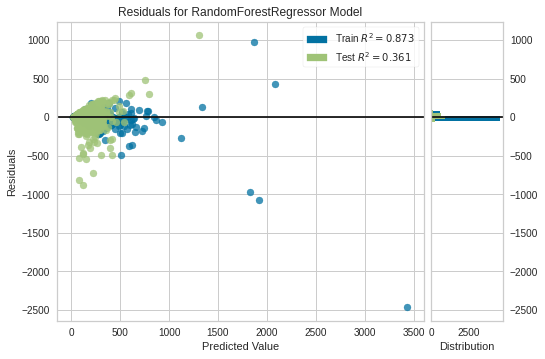

In [70]:
plot_model(tuned_rf, plot='residuals')

## Errors

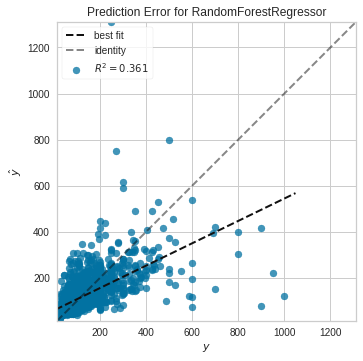

In [71]:
plot_model(tuned_rf, plot='error')

## Feature Importance

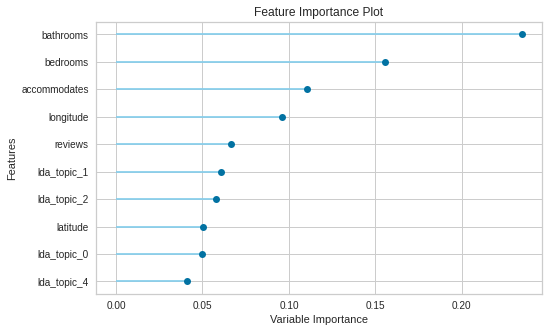

In [72]:
plot_model(tuned_rf, plot='feature')

In [61]:
predict_model(rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,39.1738,6243.0203,79.0128,0.2501,0.422,0.3749


,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,latitude,longitude,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,currency_USD,rate_type_nightly,price,Label
0,37.0,5.000000,10.0,3.0,2.0,47.637431,-122.370255,0.106325,0.575725,0.110391,0.105135,0.102424,1.0,0.0,0.0,1.0,1.0,87,236.53
1,3.0,5.000000,1.0,1.0,1.0,47.658249,-122.317639,0.106746,0.579225,0.110295,0.102682,0.101053,0.0,0.0,1.0,1.0,1.0,65,59.69
2,4.0,3.500000,3.0,1.0,1.0,47.601285,-122.334880,0.104267,0.141644,0.552406,0.101211,0.100472,1.0,0.0,0.0,1.0,1.0,80,77.30
3,4.0,5.000000,2.0,1.0,1.0,47.625500,-122.118220,0.109652,0.575510,0.112259,0.102145,0.100434,0.0,1.0,0.0,1.0,1.0,52,75.29
4,36.0,4.500000,4.0,1.0,1.0,47.663838,-122.341501,0.106306,0.302213,0.389340,0.101547,0.100594,1.0,0.0,0.0,1.0,1.0,99,92.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,90.0,5.000000,5.0,2.0,1.0,47.631304,-122.362322,0.107010,0.580395,0.110572,0.101624,0.100398,1.0,0.0,0.0,1.0,1.0,49,118.68
2269,0.0,4.841226,3.0,1.0,1.0,47.609770,-122.341231,0.106209,0.200690,0.105683,0.485093,0.102326,1.0,0.0,0.0,1.0,1.0,50,72.58
2270,361.0,5.000000,2.0,1.0,1.0,47.608130,-122.293766,0.104741,0.159673,0.533513,0.101461,0.100612,0.0,1.0,0.0,1.0,1.0,47,69.65
2271,7.0,4.500000,1.0,1.0,1.0,47.626344,-122.187849,0.545646,0.149686,0.102668,0.101455,0.100545,0.0,1.0,0.0,1.0,1.0,29,56.39
